### Get historical data 
read csv data file into a dataframe object

this is also where we take a subset of the data

Default setup is to trade on the first 92,000 minutes which is ~64 days. If you extend the time horizon, you will see the drop off in performance in the final plot.

In [30]:
import pandas
# history = pandas.read_csv('./binance_BTCUSDT_1m.csv') # bitcoin data
history = pandas.read_csv('historical_data/binance_DOGEBTC_1m.csv') # dogecoin data
# history = history.iloc[-5000:]
# history = history.iloc[0:10000]
# history = history.iloc[1000000:1020000]  # extra hard
# history = history.iloc[1000000:]  # extra hard
history

from ta.utils import dropna
# Clean NaN values
history = dropna(history)

### Use ta to get a bunch of cool metrics about the stocks (these are not used but might be useful later)
ta code can be found [here](https://github.com/bukosabino/ta) and blog post can be found [here](https://towardsdatascience.com/technical-analysis-library-to-financial-datasets-with-pandas-python-4b2b390d3543)

In [31]:
from ta import add_all_ta_features
from ta.volatility import BollingerBands


def bolly(history, window, window_dev):
    # Add all ta features (takes like 10 minutes)
    # history = add_all_ta_features(
    #                 history, open="open", high="high", low="low", close="close", volume="volume")

    # Initialize Bollinger Bands Indicator
    indicator_bb = BollingerBands(close=history["close"], window=window, window_dev=window_dev)

    # Add Bollinger Bands features
#     history['bb_bbm'] = indicator_bb.bollinger_mavg()
    history['bb_bbh'] = indicator_bb.bollinger_hband()
    history['bb_bbl'] = indicator_bb.bollinger_lband()

#     # Add Bollinger Band high indicator
#     history['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

#     # Add Bollinger Band low indicator
#     history['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

#     # Add Width Size Bollinger Bands
#     history['bb_bbw'] = indicator_bb.bollinger_wband()

#     # Add Percentage Bollinger Bands
#     history['bb_bbp'] = indicator_bb.bollinger_pband()
    
    return history

history = bolly(history, 20, 2)
history

,time,open,high,low,close,volume,bb_bbh,bb_bbl
0,1562328000,4.200000e-07,4.300000e-07,3.500000e-07,3.800000e-07,364882194.0,NaN,NaN
1,1562328060,3.900000e-07,4.000000e-07,3.800000e-07,3.800000e-07,323996565.0,NaN,NaN
2,1562328120,3.800000e-07,4.000000e-07,3.800000e-07,4.000000e-07,152876988.0,NaN,NaN
3,1562328180,4.000000e-07,4.000000e-07,3.700000e-07,3.900000e-07,114541937.0,NaN,NaN
4,1562328240,3.900000e-07,4.000000e-07,3.800000e-07,3.900000e-07,78344299.0,NaN,NaN
...,...,...,...,...,...,...,...,...
825294,1611965400,1.370000e-06,1.380000e-06,1.350000e-06,1.380000e-06,5152225.0,0.000001,0.000001
825295,1611965460,1.370000e-06,1.380000e-06,1.350000e-06,1.360000e-06,8830387.0,0.000001,0.000001
825296,1611965520,1.360000e-06,1.360000e-06,1.350000e-06,1.350000e-06,3200963.0,0.000001,0.000001
825297,1611965580,1.350000e-06,1.350000e-06,1.330000e-06,1.350000e-06,8421734.0,0.000001,0.000001


### Get price history from dataframe

In [32]:
col = 'open'     # name of column to get
p = history[col].tolist()  # price history

bb_bbh = history['bb_bbh'].tolist()
bb_bbl = history['bb_bbl'].tolist()
volume = history['volume'].tolist()

# p = p[0:10000]

t = list(range(len(p)))     # time variable

In [ ]:
max(t)

In [33]:
# these functions are used later
def avg(in_list):
    ma = 0
    num_el = len(in_list)
    
    ma = sum(in_list)
    ma = ma/num_el
    return ma

def ema(c, p, k, d):
    # EMA = (K x (C - P)) + P
    # C = Current Price
    # P = Previous periods EMA (A SMA is used for the first periods calculations)
    # K = Exponential smoothing constant
    # D = length of moving average in days
    return (c*k/(1+d))+p*(1-k/(1+d))

### Plot data

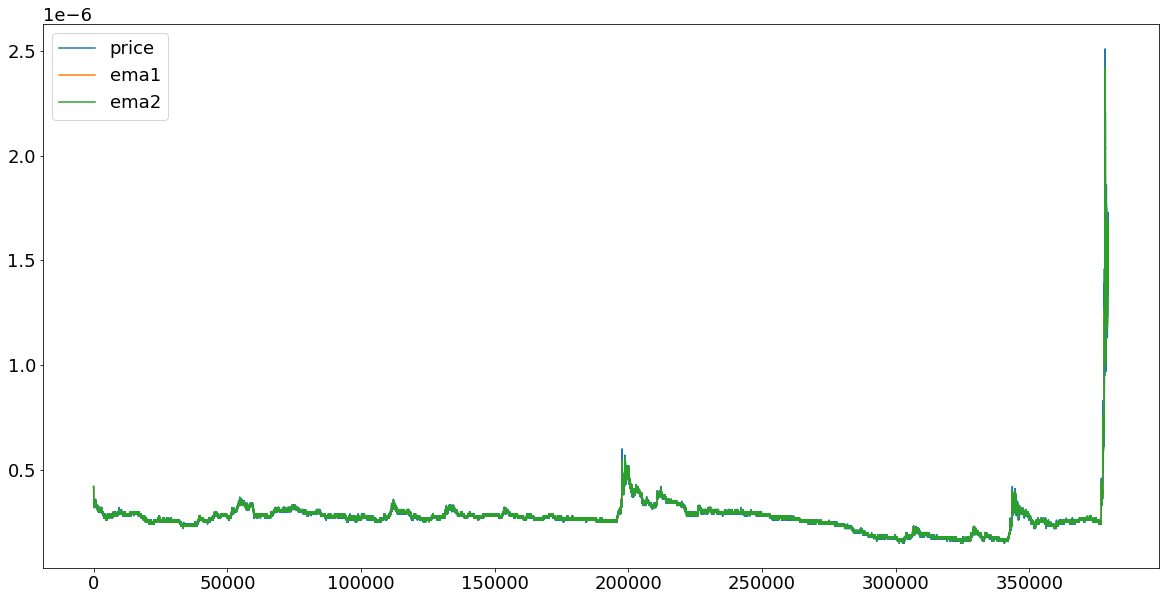

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 18})

ma = 1
ma1 = 0
ma2 = 0

sma_hist  = [0]*len(t)
ema_hist1 = [0]*len(t)
ema_hist2 = [0]*len(t)

ema_smoothing_const_1 = 0.1
ema_smoothing_const_2 = 0.2

for i in range(len(t)):
    if i == ma:
        ema_hist1[i] = avg(p[i-ma:i])
        ema_hist2[i] = avg(p[i-ma:i])
    elif i > ma:
        ema_hist1[i] = ema(p[i], ema_hist1[i-1], ema_smoothing_const_1, ma1)
        ema_hist2[i] = ema(p[i], ema_hist2[i-1], ema_smoothing_const_2, ma2)
    else:
        ema_hist1[i] = p[i]
        ema_hist2[i] = p[i]
    
plt.plot(t, p, label='price')
# ema
plt.plot(t, ema_hist1, label='ema1')
plt.plot(t, ema_hist2, label='ema2')
plt.legend()

### Find average maximum percentage after buy

# EMA CROSSOVER +EMA OPTIMIZER
this runs over the past n days (stored in list p) and finds the best ema crossover parameters (the length of each moving average, etc).

This is run quite frequently which leads to slow performance, but good trading performance.

In [35]:
def optimize(p):

    best_score = 0

    best_ema_smoothing_const_1=0 
    best_ema_smoothing_const_2=0

    best_d1 = 0
    best_d2 = 0

    net_worth = [0]*len(p)
    activity = [mean]*len(p)

    for j in range(10):
        for k in range(0,10):
            for l in range(10):
                for m in range(10):
                    cash = 100
                    doge = 0

                    d1 = j
                    d2 = k
                    
                    ema_smoothing_const_1 = l/10
                    ema_smoothing_const_2 = m/10

                    ema_hist1 = [0]*len(t)
                    ema_hist2 = [0]*len(t)

                    for i in range(len(p)):    # iterate through each day
                        price = p[i]

                        if i==0:
                            ema_hist1[i] = p[i]
                            ema_hist2[i] = p[i]

                        # trading logic

                        if i > 0:
                            ema_hist1[i] = ema(p[i], ema_hist1[i-1], ema_smoothing_const_1, d1)
                            ema_hist2[i] = ema(p[i], ema_hist2[i-1], ema_smoothing_const_2, d2)

                            percent_change = (price-prev_price)/prev_price
                            doge *= (1+percent_change)
                            
                            if ema_hist2[i] < ema_hist1[i]:
                                # buy
                                if cash > 0:
                                    doge += 0.999*cash
                                    cash -= cash
                                    activity[i] = buy

                            if ema_hist2[i] > ema_hist1[i]:
                                # sell
                                if doge > 0:
                                    cash += 0.999*doge
                                    doge -= doge
                                    activity[i] = sell

                        net_worth[i] = doge+cash
                        prev_price = price

                        if (i==len(p)-1):
                            if (doge+cash > best_score):
                                best_score = doge+cash
                                best_d1 = d1
                                best_d2 = d2
                                best_ema_smoothing_const_1 = ema_smoothing_const_1
                                best_ema_smoothing_const_2 = ema_smoothing_const_2
    
    print(best_ema_smoothing_const_2, best_d2, best_ema_smoothing_const_1, best_d1)
    return best_d1, best_d2, best_ema_smoothing_const_1, best_ema_smoothing_const_2


# d1, d2, ema_smoothing_const_1, ema_smoothing_const_2 = optimize(p[8000:16000])
# print(d1, d2)

### Run a backtest with the good parameters

In [ ]:
# run the test with the final parameters
ma1 = 1

# starting state of the algorithm, $100, no doge
cash = 1        # variable to hold number of dollars
doge = 0        # variable to hold number of dogecoins

price = 0       # current price of doge
prev_price = 0  # previous price of doge

# values that will represent buying and selling in the history of our algorithm's activity,
# I chose these values so that we could plot it alongside the stock price (eg, with the same scale).
buy = max(p)
mean = avg(p)
sell = min(p)

# start with ok moving average parameters, these will be optimized as we go
# moving average smoothing parameters
ema_smoothing_const_1 = 0.1
ema_smoothing_const_2 = 0.1
# length of each moving average parameter
d1 = 1
d2 = 0

print('Parameters ema_smoothing_const_1='+str(ema_smoothing_const_1),'ema_smoothing_const_2='+str(ema_smoothing_const_2))
print('Parameters d1='+str(d1),'d2='+str(d2))

ema_hist1 = [0]*len(t)
ema_hist2 = [0]*len(t)

activity = [mean]*len(p)  # tells us when algo buys or sells
net_worth = [0]*len(p)  # how much money is in our account over time

progress = 0 # used for printing progress reports


ema_hist1[0] = p[0]
ema_hist2[0] = p[0]

import time

for i in t:    # iterate through each day
    price = p[i]
    
#     if i % int(t[-1]/200) == 0:
#         print(str(progress)+'/200 of the way done')
#         print('worth', str(cash+doge))
#         progress += 1
    
    # optimize the trading parameters over the last 1000 minutes
    if i % 1001 == 0 :
        t0 = time.perf_counter()
        d1, d2, ema_smoothing_const_1, ema_smoothing_const_2 = optimize(p[i-1000:i])
        print(time.perf_counter() - t0)
    
    # trading logic
    if i > 0:
        ema_hist1[i] = ema(p[i], ema_hist1[i-1], ema_smoothing_const_1, d1)
        ema_hist2[i] = ema(p[i], ema_hist2[i-1], ema_smoothing_const_2, d2)

        percent_change = (price-prev_price)/prev_price
        doge *= (1+percent_change)
        
        if (ema_hist2[i] < ema_hist1[i]):
            # buy all doge
            if cash > 0:
                doge += 0.999*cash
                cash -= cash
                activity[i] = buy

        if (ema_hist2[i] > ema_hist1[i]):
            # sell all doge
            if doge > 0:
                cash += 0.999*doge
                doge -= doge
                activity[i] = sell

        prev_price = price

    net_worth[i] = doge + cash
    print(net_worth[i])
    prev_price = price

Parameters ema_smoothing_const_1=0.1 ema_smoothing_const_2=0.1
Parameters d1=1 d2=0
0 0 0 0
23.166018797000106
1
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

0.8 0 0.4 0
47.00425263700026
204.2124529975941
204.2124529975941
204.2124529975941
204.00824054459653
210.597706714187
210.38710900747282
210.38710900747282
210.38710900747282
217.1826126284142
216.96543001578578
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.9734134052957
223.7494399918904
223.7494399918904
230.97654690362847
230.74557035672484
238.19865227924709
238.19865227924709
238.19865227924709
238.19865227924709
237.96045362696785
245.64657627911896
245.64657627911896
245.64657627911896
245.64657627911896
245.40092970283985
253.32737973224158
253.32737973224158
253.32737973224158
253.32737973224158
253.32737973224158
253.32737973224158
253.07405235250934
253.07405235250934
260.97649372919415
260.97649372919415
260.97649372919415
260.715517235465
260.715517235465
260.715517235465
268.85656951559173
268.5877129460761
268.5877129460761
268.58771

ValueError: x and y must have same first dimension, but have shapes (0,) and (6295,)

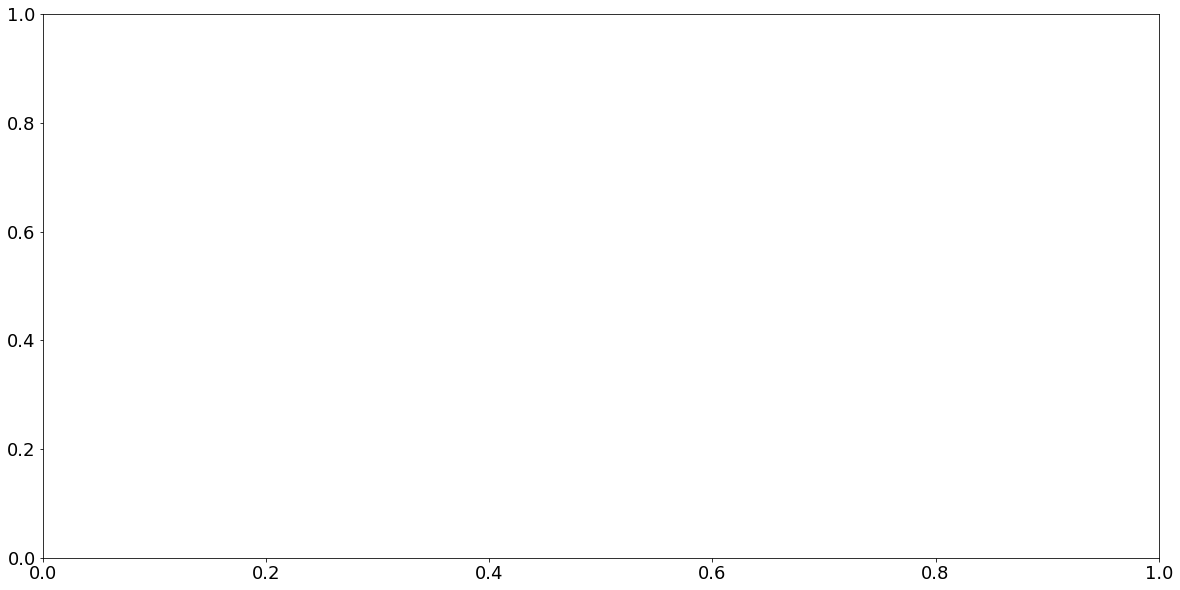

In [29]:
# plot the activity along with the stock price
plt.plot(t, activity)
plt.plot(t, p)
plt.plot(t, ema_hist1)
plt.plot(t, ema_hist2)
plt.xlim([2000, 2100])
plt.xlabel('time (minutes)')
plt.ylabel('trading action')
plt.title('Trading activity')
plt.grid(True)
plt.show()

In [ ]:
# plot the net worth of the trading strategy over time

# compare the trading strategy to buying at the beginning and doing nothing/holding
hold = 100*(p[-1]-p[0])/p[0]
print('net worth with hold strategy', str(hold))
print('net worth with moving average strategy', str(net_worth[-1]))
plt.plot(t, net_worth)
plt.title('net worth with moving average crossover strategy')
plt.xlabel('time (minutes)')
plt.ylabel('net worth')
plt.show()

In [21]:
t

[]